# Food-101 Classification Model

### Load the necessary packages

In [1]:
import os, sys
from os import listdir
from os.path import isfile, join
import seaborn as sns
from collections import defaultdict
import shutil

# PyTorch
import torchvision
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

from torch_lr_finder import LRFinder

# Data science tools
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# Image manipulations
from PIL import Image
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
from IPython.display import display, Image
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import warnings
warnings.filterwarnings('ignore')

import itertools
from itertools import cycle

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
  pip install torch-lr-finder -v --global-option="amp"


## Preliminary Data Wrangling and Exploratory Data Analysis

Description of data:
This dataset contains labeled food images with 101 different categories. For each category there is 1,000 total images, making the total amount of images 101,000.

For this project the final split of the data will be 75% training images, 12.5% testing images, and 12.5% validation images.

This document will explore the dataset and will make preliminary insights about the dataset. The goal is to build a model that will be able to identify user generated photo's within these categories. 

In [2]:
# load training dataframe
train_df = pd.read_json('../data/meta/test.json')
train_df.head()

,churros,hot_and_sour_soup,samosa,sashimi,pork_chop,spring_rolls,panna_cotta,beef_tartare,greek_salad,foie_gras,...,chicken_quesadilla,pho,prime_rib,cheesecake,ice_cream,omelette,grilled_cheese_sandwich,lobster_roll_sandwich,nachos,oysters
0,churros/1061830,hot_and_sour_soup/1000486,samosa/1009326,sashimi/100113,pork_chop/1012227,spring_rolls/1005480,panna_cotta/1006650,beef_tartare/101073,greek_salad/1010850,foie_gras/1007306,...,chicken_quesadilla/10257,pho/1002382,prime_rib/1006976,cheesecake/1023543,ice_cream/1004744,omelette/1019294,grilled_cheese_sandwich/1000938,lobster_roll_sandwich/1002698,nachos/1011831,oysters/1005672
1,churros/1064042,hot_and_sour_soup/1004564,samosa/1024186,sashimi/1017182,pork_chop/1019077,spring_rolls/103010,panna_cotta/1027460,beef_tartare/1029120,greek_salad/1029680,foie_gras/1044237,...,chicken_quesadilla/1030292,pho/1020153,prime_rib/102197,cheesecake/102854,ice_cream/1031536,omelette/1058816,grilled_cheese_sandwich/1003050,lobster_roll_sandwich/1029665,nachos/101954,oysters/1017801
2,churros/1074903,hot_and_sour_soup/1011278,samosa/1036216,sashimi/1043094,pork_chop/102958,spring_rolls/1036175,panna_cotta/1030883,beef_tartare/1030025,greek_salad/1053670,foie_gras/1073688,...,chicken_quesadilla/1052529,pho/1026354,prime_rib/102813,cheesecake/1073148,ice_cream/1075106,omelette/1116874,grilled_cheese_sandwich/1005927,lobster_roll_sandwich/103891,nachos/103312,oysters/1019666
3,churros/1085259,hot_and_sour_soup/1029400,samosa/103689,sashimi/1050391,pork_chop/1040432,spring_rolls/1044858,panna_cotta/103712,beef_tartare/1031053,greek_salad/1062715,foie_gras/1113614,...,chicken_quesadilla/1096804,pho/1028507,prime_rib/1035695,cheesecake/1092082,ice_cream/1100243,omelette/1122818,grilled_cheese_sandwich/100694,lobster_roll_sandwich/104300,nachos/1044020,oysters/1040557
4,churros/1097261,hot_and_sour_soup/1044215,samosa/1052427,sashimi/10551,pork_chop/1045605,spring_rolls/1067952,panna_cotta/1050629,beef_tartare/1066933,greek_salad/1101710,foie_gras/1125178,...,chicken_quesadilla/1102036,pho/1029709,prime_rib/105375,cheesecake/1096018,ice_cream/1106165,omelette/1145379,grilled_cheese_sandwich/1052563,lobster_roll_sandwich/1046809,nachos/1060157,oysters/1044823


In [3]:
# load testing dataframe
test_df = pd.read_json('../data/meta/train.json')
test_df.head()

,churros,hot_and_sour_soup,samosa,sashimi,pork_chop,spring_rolls,panna_cotta,beef_tartare,greek_salad,foie_gras,...,chicken_quesadilla,pho,prime_rib,cheesecake,ice_cream,omelette,grilled_cheese_sandwich,lobster_roll_sandwich,nachos,oysters
0,churros/1004234,hot_and_sour_soup/1002782,samosa/1008131,sashimi/1001239,pork_chop/1000802,spring_rolls/1002160,panna_cotta/1001332,beef_tartare/1000431,greek_salad/1007149,foie_gras/1004944,...,chicken_quesadilla/1004279,pho/1005681,prime_rib/1001089,cheesecake/1001446,ice_cream/1012277,omelette/1001719,grilled_cheese_sandwich/1003153,lobster_roll_sandwich/100009,nachos/100284,oysters/1008124
1,churros/1013460,hot_and_sour_soup/1003688,samosa/1011601,sashimi/1001363,pork_chop/1006233,spring_rolls/1003056,panna_cotta/1003460,beef_tartare/1005746,greek_salad/1009138,foie_gras/1008577,...,chicken_quesadilla/1009225,pho/1011443,prime_rib/1006320,cheesecake/1004515,ice_cream/101858,omelette/1007843,grilled_cheese_sandwich/10060,lobster_roll_sandwich/1001432,nachos/1009513,oysters/1016229
2,churros/1016791,hot_and_sour_soup/1008185,samosa/101365,sashimi/1002556,pork_chop/1019530,spring_rolls/1003507,panna_cotta/1011097,beef_tartare/1009672,greek_salad/1010520,foie_gras/1011711,...,chicken_quesadilla/1011413,pho/1012513,prime_rib/100945,cheesecake/1004807,ice_cream/102595,omelette/1015300,grilled_cheese_sandwich/1007544,lobster_roll_sandwich/100646,nachos/1011394,oysters/1023832
3,churros/102100,hot_and_sour_soup/1008701,samosa/1015943,sashimi/1007253,pork_chop/1019569,spring_rolls/1008736,panna_cotta/1013000,beef_tartare/1012128,greek_salad/1011665,foie_gras/1017233,...,chicken_quesadilla/1023828,pho/1019401,prime_rib/10120,cheesecake/1017408,ice_cream/1044117,omelette/1029915,grilled_cheese_sandwich/1013343,lobster_roll_sandwich/100655,nachos/1013641,oysters/103236
4,churros/1025494,hot_and_sour_soup/1008924,samosa/1016296,sashimi/1010510,pork_chop/1025391,spring_rolls/1012525,panna_cotta/1020036,beef_tartare/1027680,greek_salad/1012989,foie_gras/1023512,...,chicken_quesadilla/1024740,pho/1021371,prime_rib/1016126,cheesecake/1021942,ice_cream/104465,omelette/1038109,grilled_cheese_sandwich/1016030,lobster_roll_sandwich/100702,nachos/1014846,oysters/1038150


### Random Samples Per Label

In [4]:
def gather_image_data(root_dir, food_dir):
    # root_dir = root directory of the image data
    # food_dir is the specific food directory you wish to gather the data from
    files_in_folder = os.listdir(os.path.join(root_dir,food_dir))
    random_image = np.random.choice(files_in_folder)
    return plt.imread(os.path.join(root_dir,food_dir,random_image))

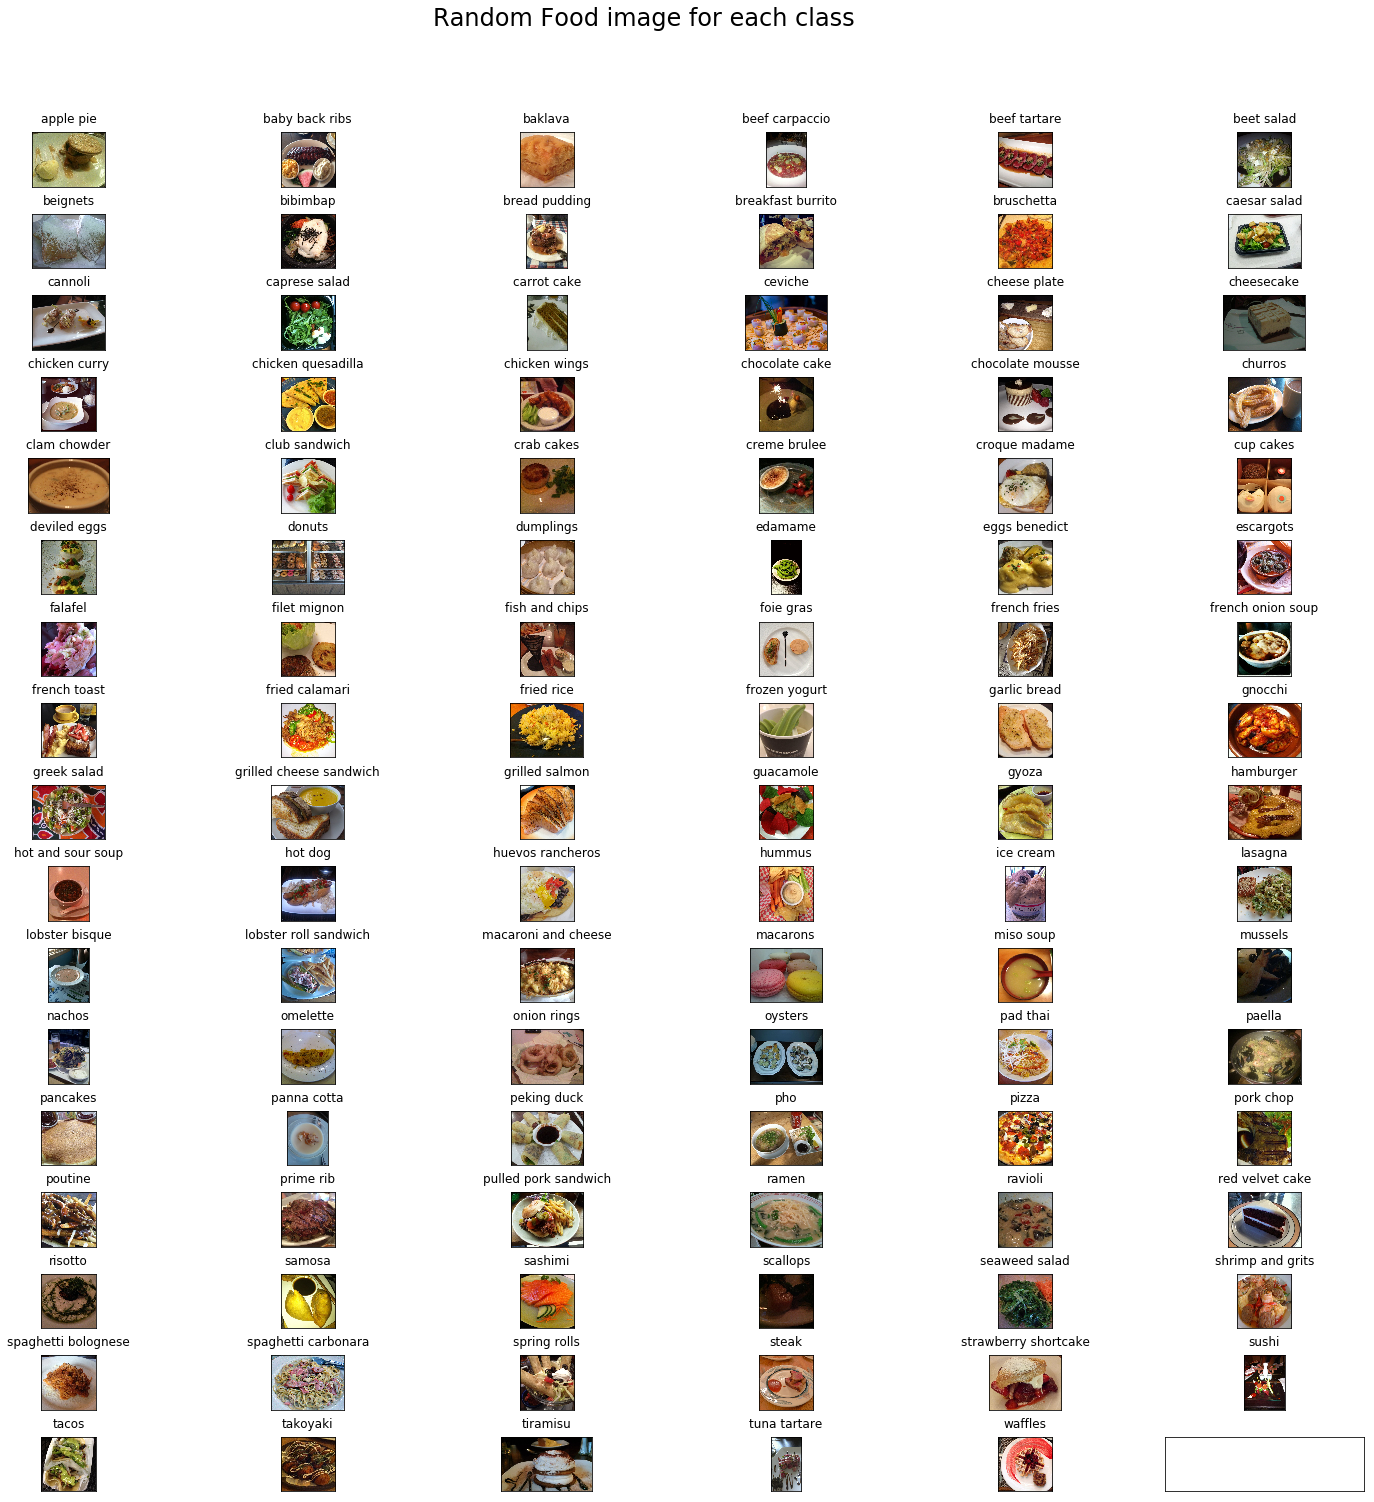

In [5]:
# setup root directory and grid size
root_dir = '../data/images'
row = 17
col = 6

# initiate subplot and configure title
fig, ax = plt.subplots(row,col,figsize=(25,25))
fig.suptitle("Random Food image for each class", y=.95, fontsize=24)
plt.setp(ax, xticks=[],yticks=[])
plt.subplots_adjust(hspace=0.5)

# gather food directory's for all 101 types of food
sorted_food_dirs = sorted(os.listdir(root_dir))

# iterate through each category of food and assign a random image to a spot on the grid
for i in range(row):
    for j in range(col):
        try:
            food_dir = sorted_food_dirs[i * col + j]
        except:
            break
        img = gather_image_data(root_dir,food_dir)
        ax[i][j].imshow(img)
        ax[i][j].set_title(food_dir.replace("_"," "), pad = 10)

plt.show();

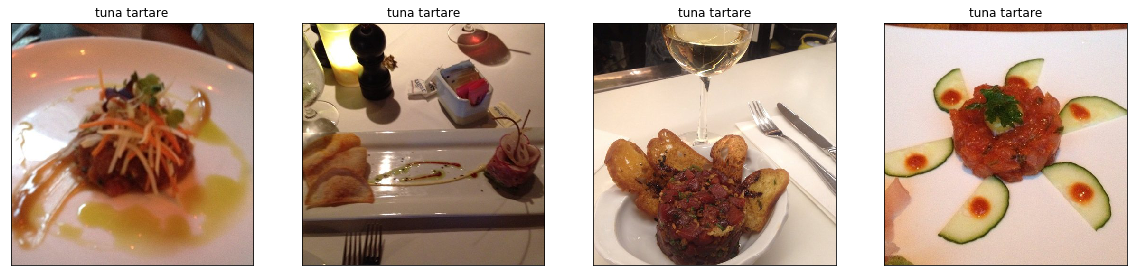

In [6]:
root_dir = '../data/images'
# Select a food directory from above to display images from it
food_dir = 'tuna tartare'.replace(" ","_")
files_in_folder = os.listdir(os.path.join(root_dir,food_dir))

# initiate subplot
fig, ax = plt.subplots(1,4,figsize=(20,15))
plt.setp(ax, xticks=[],yticks=[])

# fill 4 subplots
for i in range(4):
    img = gather_image_data(root_dir,food_dir)
    ax[i].imshow(img)
    ax[i].set_title(food_dir.replace("_"," "))
plt.show();


### Review JSON Data
It appears that the .json data is seperated by label with a list of file locations for the images.

In [7]:
train_df.head()

,churros,hot_and_sour_soup,samosa,sashimi,pork_chop,spring_rolls,panna_cotta,beef_tartare,greek_salad,foie_gras,...,chicken_quesadilla,pho,prime_rib,cheesecake,ice_cream,omelette,grilled_cheese_sandwich,lobster_roll_sandwich,nachos,oysters
0,churros/1061830,hot_and_sour_soup/1000486,samosa/1009326,sashimi/100113,pork_chop/1012227,spring_rolls/1005480,panna_cotta/1006650,beef_tartare/101073,greek_salad/1010850,foie_gras/1007306,...,chicken_quesadilla/10257,pho/1002382,prime_rib/1006976,cheesecake/1023543,ice_cream/1004744,omelette/1019294,grilled_cheese_sandwich/1000938,lobster_roll_sandwich/1002698,nachos/1011831,oysters/1005672
1,churros/1064042,hot_and_sour_soup/1004564,samosa/1024186,sashimi/1017182,pork_chop/1019077,spring_rolls/103010,panna_cotta/1027460,beef_tartare/1029120,greek_salad/1029680,foie_gras/1044237,...,chicken_quesadilla/1030292,pho/1020153,prime_rib/102197,cheesecake/102854,ice_cream/1031536,omelette/1058816,grilled_cheese_sandwich/1003050,lobster_roll_sandwich/1029665,nachos/101954,oysters/1017801
2,churros/1074903,hot_and_sour_soup/1011278,samosa/1036216,sashimi/1043094,pork_chop/102958,spring_rolls/1036175,panna_cotta/1030883,beef_tartare/1030025,greek_salad/1053670,foie_gras/1073688,...,chicken_quesadilla/1052529,pho/1026354,prime_rib/102813,cheesecake/1073148,ice_cream/1075106,omelette/1116874,grilled_cheese_sandwich/1005927,lobster_roll_sandwich/103891,nachos/103312,oysters/1019666
3,churros/1085259,hot_and_sour_soup/1029400,samosa/103689,sashimi/1050391,pork_chop/1040432,spring_rolls/1044858,panna_cotta/103712,beef_tartare/1031053,greek_salad/1062715,foie_gras/1113614,...,chicken_quesadilla/1096804,pho/1028507,prime_rib/1035695,cheesecake/1092082,ice_cream/1100243,omelette/1122818,grilled_cheese_sandwich/100694,lobster_roll_sandwich/104300,nachos/1044020,oysters/1040557
4,churros/1097261,hot_and_sour_soup/1044215,samosa/1052427,sashimi/10551,pork_chop/1045605,spring_rolls/1067952,panna_cotta/1050629,beef_tartare/1066933,greek_salad/1101710,foie_gras/1125178,...,chicken_quesadilla/1102036,pho/1029709,prime_rib/105375,cheesecake/1096018,ice_cream/1106165,omelette/1145379,grilled_cheese_sandwich/1052563,lobster_roll_sandwich/1046809,nachos/1060157,oysters/1044823


In [8]:
test_df.head()

,churros,hot_and_sour_soup,samosa,sashimi,pork_chop,spring_rolls,panna_cotta,beef_tartare,greek_salad,foie_gras,...,chicken_quesadilla,pho,prime_rib,cheesecake,ice_cream,omelette,grilled_cheese_sandwich,lobster_roll_sandwich,nachos,oysters
0,churros/1004234,hot_and_sour_soup/1002782,samosa/1008131,sashimi/1001239,pork_chop/1000802,spring_rolls/1002160,panna_cotta/1001332,beef_tartare/1000431,greek_salad/1007149,foie_gras/1004944,...,chicken_quesadilla/1004279,pho/1005681,prime_rib/1001089,cheesecake/1001446,ice_cream/1012277,omelette/1001719,grilled_cheese_sandwich/1003153,lobster_roll_sandwich/100009,nachos/100284,oysters/1008124
1,churros/1013460,hot_and_sour_soup/1003688,samosa/1011601,sashimi/1001363,pork_chop/1006233,spring_rolls/1003056,panna_cotta/1003460,beef_tartare/1005746,greek_salad/1009138,foie_gras/1008577,...,chicken_quesadilla/1009225,pho/1011443,prime_rib/1006320,cheesecake/1004515,ice_cream/101858,omelette/1007843,grilled_cheese_sandwich/10060,lobster_roll_sandwich/1001432,nachos/1009513,oysters/1016229
2,churros/1016791,hot_and_sour_soup/1008185,samosa/101365,sashimi/1002556,pork_chop/1019530,spring_rolls/1003507,panna_cotta/1011097,beef_tartare/1009672,greek_salad/1010520,foie_gras/1011711,...,chicken_quesadilla/1011413,pho/1012513,prime_rib/100945,cheesecake/1004807,ice_cream/102595,omelette/1015300,grilled_cheese_sandwich/1007544,lobster_roll_sandwich/100646,nachos/1011394,oysters/1023832
3,churros/102100,hot_and_sour_soup/1008701,samosa/1015943,sashimi/1007253,pork_chop/1019569,spring_rolls/1008736,panna_cotta/1013000,beef_tartare/1012128,greek_salad/1011665,foie_gras/1017233,...,chicken_quesadilla/1023828,pho/1019401,prime_rib/10120,cheesecake/1017408,ice_cream/1044117,omelette/1029915,grilled_cheese_sandwich/1013343,lobster_roll_sandwich/100655,nachos/1013641,oysters/103236
4,churros/1025494,hot_and_sour_soup/1008924,samosa/1016296,sashimi/1010510,pork_chop/1025391,spring_rolls/1012525,panna_cotta/1020036,beef_tartare/1027680,greek_salad/1012989,foie_gras/1023512,...,chicken_quesadilla/1024740,pho/1021371,prime_rib/1016126,cheesecake/1021942,ice_cream/104465,omelette/1038109,grilled_cheese_sandwich/1016030,lobster_roll_sandwich/100702,nachos/1014846,oysters/1038150


### Copy Train and Test images into respective folders

In [9]:
# create functions for copying files and ignoring files

def copytree(src, dst, ignored_ids = None):
    # src = source directory
    # dst = destination directory of copy
    # ignore = ignore function that provides list of id's to ignore based on testing or training set
    
    # if destination directory does not exist, create directory
    if not os.path.exists(dst):
        os.makedirs(dst)
        shutil.copystat(src, dst)
    
    # get list of directories in current directory
    directory_items = os.listdir(src)
    # filter out items to be ignored
    directory_items = [x for x in directory_items if x not in ignored_ids]
    # for each item in directory, copy into destination
    for item in directory_items:
        source = os.path.join(src, item)
        destination = os.path.join(dst, item)
        # if item is a directory, recurisvely call this function 
        if os.path.isdir(source):
            print(source)
            copytree(source, destination, ignored_ids)
        # copy item to destination
        else:
            shutil.copy2(source, destination)

# generate list of folders and filenames in directory from metadata txt file
# returns a list
def generate_dir_file_map(path):
    dir_files = defaultdict(list)
    with open(path, 'r') as txt:
        files = [l.strip() for l in txt.readlines()]
        for f in files:
            dir_name, id = f.split('/')
            dir_files[dir_name].append(id + '.jpg')
    return dir_files

# generate list of id's of training images
def generate_training_ids():
    train_dir_files = generate_dir_file_map('../data/meta/train.txt')
    ids_to_ignore = list()
    for category in train_dir_files:
        for file in train_dir_files[category]:
            ids_to_ignore.append(file)
    return ids_to_ignore

# generate list of id's of using the first half of the testing images
def generate_testing_ids():
    test_dir_categories = generate_dir_file_map('../data/meta/test.txt')
    ids_to_ignore = list()
    for category in test_dir_categories:
        first_half_of_test_ids = test_dir_categories[category][:len(test_dir_categories[category])//2]
        for image_id in first_half_of_test_ids:
            ids_to_ignore.append(image_id)
    return ids_to_ignore

# generate list of id's of using the second half of the testing images
def generate_validation_ids():
    test_dir_categories = generate_dir_file_map('../data/meta/test.txt')
    ids_to_ignore = list()
    for category in test_dir_categories:
        second_half_of_test_ids = test_dir_categories[category][len(test_dir_categories[category])//2:]
        for image_id in second_half_of_test_ids:
            ids_to_ignore.append(image_id)
    return ids_to_ignore

In [10]:
len(generate_testing_ids())

12625

In [11]:
def sort_images():
    # Only split files if haven't already
    ids_to_ignore_for_training = generate_testing_ids() + generate_validation_ids()
    ids_to_ignore_for_testing = generate_training_ids() + generate_validation_ids()
    ids_to_ignore_for_validation = generate_testing_ids() + generate_training_ids()
    
    root_dir = '../data/images'
    train_dir = '../data/train'
    test_dir = '../data/test'
    valid_dir = '../data/valid'
    
    if not os.path.isdir('../data/train'):
        copytree(root_dir, train_dir, ignored_ids=ids_to_ignore_for_training)
    else:
        print('Train files already copied into separate folders.')

    if not os.path.isdir('../data/test'):
        copytree(root_dir, test_dir, ignored_ids=ids_to_ignore_for_testing)
    else:
        print('Test files already copied into separate folders.')

    if not os.path.isdir('../data/valid'):
        copytree(root_dir, valid_dir, ignored_ids=ids_to_ignore_for_validation)
    else:
        print('Validation files already copied into separate folders.')
        
sort_images()

Train files already copied into separate folders.
Test files already copied into separate folders.
Validation files already copied into separate folders.


## Training the Model
### Initalize parameters

In [12]:
# Location of data
data_dir = '../data/'
train_dir = data_dir + 'train/'
valid_dir = data_dir + 'valid/'
test_dir = data_dir + 'test/'

save_file_name = 'resnet50-transfer11.pt'
checkpoint_file_name = 'resnet50-transfer11.pth'

# Change to fit hardware
batch_size = 32

image_size = 224

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


In [13]:
# set random seeds
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(42)

### Image Augmentation

I chose to use lot of image pre-processing for the training data. This will allow the model to better generalize for unseen data.

In [14]:
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=image_size),
        transforms.RandomRotation(degrees=45),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(45),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.CenterCrop(size=image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.CenterCrop(size=image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Data Iterators

In [15]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [16]:
# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=train_dir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=valid_dir, transform=image_transforms['val']),
    'test':
    ImageFolderWithPaths(root=test_dir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=False)
}

### Model Setup
#### Load Pre-trained ResNet50Model

I use ResNet50 for a couple reasons.
1. The image size is 224 x 224, which is mostly standard with other pre-trained CNN's. The smaller pixel size compared to some out there (299 x 299 in the case of Inception) will allow for faster training and bigger batch sizes.
2. It is a mid-size network. With ResNets going as low as 18 and high as 152 and above, 50 gives a nice sweet spot between size and complexity. While I may be able to get better results with a larger network, the training time and hardware requirements will be higher.

In [17]:
model = models.resnet50(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Freeze weights of early layers of the VGG16 Model

In [18]:
for param in model.parameters():
    param.requires_grad = False

#### Replace Last layer with fully connected layer configured for the task at hand

To finish modifying the ResNet50 pre-trained network I replace the last fully connected layer and replace it with two fully connected layers and a LeakyReLU function after the first one. I chose to use two so I could down sample the outgoing features of the pre-trained model and the new layers to first the pixel size of the image, then to the number of classes in the dataset.

If I had more time I would experiment with the configuration of these last layers as I have seen increases and decreases in the accuracy simply based on the layers a the end of the network.

In [19]:
n_classes = 101

n_inputs = model.fc.in_features

classifier = nn.Sequential(
    nn.Linear(n_inputs,image_size),
    nn.LeakyReLU(),
    nn.Linear(image_size,n_classes)
    )

model.fc = classifier
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Move model to GPU

This will allow the model to train quicker by taking advantage of a GPU if the learning environment has one.

In [20]:

if train_on_gpu:
    model = model.to('cuda')

if multi_gpu:
    model = nn.DataParallel(model)

### Finding the Right Learning Rate

In order to use a Cyclic Learning Rate scheduler efficiently, you must first find the bounds between the upper and lower limit learning rates to be used with the scheduler defined below.

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


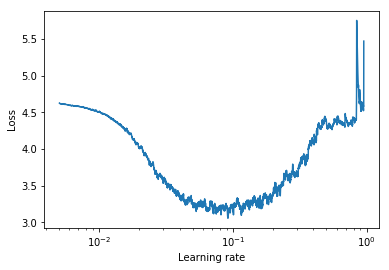

In [21]:
# we will be using negative log likelihood as the loss function
criterion = nn.CrossEntropyLoss()
# we will be using the SGD optimizer as our optimizer
optimizer = optim.SGD(model.fc.parameters(), lr=5e-3)
lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
lr_finder.range_test(dataloaders['train'], end_lr=1, num_iter=5000)
lr_finder.plot()
lr_finder.reset()

### Training Loss and Optimizer

The loss function I use is Cross Entropy Loss because it is commonly used in classification models. It works by comparing predicted probabilities of the datapoint is and the actual label. The loss increases as the difference predicted probability is from the actual point.

For the optimizer I chose to use Stochastic Gradient Descent (SGD). At first I used the ADAM optimizer to prototype the model, however once I knew everything else was in place and working I switched over to SGD to give me a more fine tuned approach to exploring the gradient of the data. 

Along with using SGD as my optimizer, I pair it with a Cyclical Learning Rate scheduler. This allows the model to get a better lay of the land by cycling between a lower and upper bound learning rate. Doing this allows the model to explore the gradient curve in more than one direction and hopefully avoid getting stuck in a local minima.

In [22]:
# we will be using negative log likelihood as the loss function
criterion = nn.CrossEntropyLoss()
# we will be using the Adam optimizer as our optimizer
optimizer = optim.SGD(model.fc.parameters(), lr=1e-1, momentum=0.9)

# secify learning rate scheduler (if there is no further decrease in loss for next 5 epochs 
# then lower the learning rate by 0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, max_lr=1e-1, base_lr=1e-2, mode='triangular')

### Training the Model

The model will train in two phases.
In phase one we train the model while only updating the weights on the new classifier layers that we added to the pre-trained ResNet50 model. This will allow training to focus on the last few layers and ensure that they are trained accordingly with the data. This phase will continue until the training loss becomes greater than the validation loss for a certain amount of training epochs, in this case 10. I use that as a metric to stop training because it is an indicator that the model is becoming overfitted to the training data. The validation loss is naturally smaller than the training loss in this example because of the amount of image transformations we are doing before feeding the images into the model. I chose to do this to allow the model to be able to generalize better to unseen data.

Phase two of training will be almost identical to phase one, with the exception of unfreezing all layers of the model to allow the training process to update the weights of the rest of the layers. This will continue until the training loss becomes smaller than the valid loss for a certain amount of epochs.

In [23]:
def train_model(model,
                criterion,
                optimizer,
                scheduler,
                train_loader,
                valid_loader,
                save_file_name,
                checkpoint_file_name,
                early_stopping_patience=100,
                overfit_patience=15,
                n_epochs=25,
                print_every=2,
                valid_every=2
               ):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """
    # early stopping initializaiton
    epochs_no_improve = 0
    epochs_overfit = 0
    valid_loss_min = np.Inf
    
    valid_max_acc = 0
    history = []
    
    # number of epochs already trained (if using loaded in model weights)
    try:
        print("Model has been trained for: {} epochs.\n".format(model.epochs))
    except:
        model.epochs = 0
        print("Starting training from scratch.\n")
        
    overall_start = timer()
    
    #Main loop
    for epoch in range(n_epochs):
        
        #keep track of training and validation loss of each epoch
        train_loss = 0.0
        valid_loss = 0.0
        
        train_acc = 0
        valid_acc = 0
        
        #set to training
        model.train()
        start = timer()
        
        # training loop
        for ii, (data, target) in enumerate(train_loader):
            #tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
                
            # clear gradients
            optimizer.zero_grad()
            #predicted outpouts are log probabilities
            output = model(data)
            
            # loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()
            
            # update the parameters
            optimizer.step()
            
            # track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)
            
            # calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)
            
            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')
        # after training loop ends
        else:
            model.epochs += 1
            
            if model.epochs > 1 and (model.epochs % valid_every == 0): 
                # don't need to keep track of gradients
                with torch.no_grad():
                    # set to evaluation mode
                    model.eval()

                    #validation loop
                    for data, target in valid_loader:
                        #tensors to gpu
                        if train_on_gpu:
                            data, target = data.cuda(), target.cuda()

                        # Forward pass
                        output = model(data)

                        # validation loss 
                        loss = criterion(output, target)
                        # multiply average loss times the number of examples in batch
                        valid_loss += loss.item() * data.size(0)

                        # calculate validation accuracy
                        _, pred = torch.max(output, dim=1)
                        correct_tensor = pred.eq(target.data.view_as(pred))
                        accuracy = torch.mean(
                            correct_tensor.type(torch.FloatTensor))
                        # multiply average accuracy times the number of examples
                        valid_acc += accuracy.item() * data.size(0)

                    # calculate average losses
                    train_loss = train_loss / (len(train_loader.dataset))
                    valid_loss = valid_loss / (len(valid_loader.dataset))

                    # calculate average accuracy
                    train_acc = train_acc / (len(train_loader.dataset))
                    valid_acc = valid_acc / (len(valid_loader.dataset))

                    # learning rate scheduler step
                    scheduler.step(valid_loss)

                    history.append([train_loss, valid_loss, train_acc, valid_acc, model.epochs])

                    # Print training and validation results
                    if (model.epochs + 1) % valid_every == 0:
                        print(
                            f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                        )
                        print(
                            f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                        )

                    # save the model if validation loss decreases
                    if valid_loss < valid_loss_min:
                        print("Valid loss decreased ({:.6f} --> {:.6f}). Saving model...".format(valid_loss_min, valid_loss))

                        # save model
                        torch.save(model.state_dict(), save_file_name)

                        checkpoint = {
                            "model": model,
                            "criterion": criterion,
                            "epochs": model.epochs,
                            "optimizer_state": optimizer.state_dict(),
                            "model_state": model.state_dict(),
                            "valid_loss_min": valid_loss
                        }
                        torch.save(checkpoint, checkpoint_file_name)

                        # track improvements
                        epochs_no_improve = 0
                        epochs_overfit = 0
                        valid_loss_min = valid_loss
                        valid_best_acc = valid_acc
                        best_epoch = epoch

                    # otherwise increment count of epochs with no improvement
                    elif train_loss < valid_loss:
                        epochs_overfit += 1
                        if epochs_overfit >= overfit_patience:
                            print(f'\n Valid loss has increased larger than training loss for {epochs_overfit} epochs')
                            print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                            )
                            # load the best state dict
                            model.load_state_dict(torch.load(save_file_name))
                            # attach the optimizer
                            model.optimizer = optimizer

                            # format history
                            history = pd.DataFrame(
                                    history,
                                    columns=[
                                        'train_loss', 'valid_loss', 'train_acc',
                                        'valid_acc', 'epochs'
                                    ])
                            return model, history

                    else:
                        epochs_no_improve += 1
                        #trigger early stopping
                        # this should be not going bad
                        if (epochs_no_improve >= early_stopping_patience):
                            print(
                                f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                            )
                            total_time = timer() - overall_start
                            print(
                                f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                            )

                            # load the best state dict
                            model.load_state_dict(torch.load(save_file_name))
                            # attach the optimizer
                            model.optimizer = optimizer

                            # format history
                            history = pd.DataFrame(
                                    history,
                                    columns=[
                                        'train_loss', 'valid_loss', 'train_acc',
                                        'valid_acc', 'epochs'
                                    ])
                            return model, history
                        
    model.optimizer = optimizer
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (model.epochs):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [ ]:
model, history = train_model(
    model,
    criterion,
    optimizer,
    scheduler,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    checkpoint_file_name=checkpoint_file_name,
    early_stopping_patience=50,
    overfit_patience=10,
    n_epochs=200,
    print_every=10
    )

Starting training from scratch.



In [ ]:
# summarize history for accuracy
plt.plot(history['train_acc'])
plt.plot(history['valid_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('train_valid_accuracy.png')
plt.show();


# summarize history for loss
plt.plot(history['train_loss'])
plt.plot(history['valid_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('train_valid_loss.png')

plt.show();


In [ ]:
# unfreeze all layers of the model to allow them to start training
for param in model.parameters():
    param.requires_grad = True

In [ ]:
model, history = train_model(
    model,
    criterion,
    optimizer,
    scheduler,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    checkpoint_file_name=checkpoint_file_name,
    early_stopping_patience=50,
    overfit_patience=10,
    n_epochs=200,
    print_every=10
    )

In [ ]:
# summarize history for accuracy
plt.plot(history['train_acc'])
plt.plot(history['valid_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show();
# summarize history for loss
plt.plot(history['train_loss'])
plt.plot(history['valid_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show();

### Model Evaluation

In [ ]:
def get_labels():
    food_labels = pd.read_csv("../data/meta/labels.txt", header=None)
    food_labels = food_labels[0].tolist()
    return food_labels

In [ ]:
if train_on_gpu:
    model.load_state_dict(torch.load('../saved_models/resnet50-transfer10.pt', map_location= torch.device('cuda')))
    model.to('cuda')
else:
    model.load_state_dict(torch.load('../saved_models/resnet50-transfer10.pt', map_location= torch.device('cpu')))
    model.to('cpu')
model.eval();

In [ ]:
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
total_correct = 0
total = 0
y_test = []
y_pred = []

with torch.no_grad():
    for data, target in dataloaders['test']:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        y_test.extend(target.cpu().numpy().tolist())
        y_pred.extend(predicted.cpu().numpy().tolist())
        c = (predicted == target).squeeze()
        total += labels.size(0)
        total_correct += (predicted == target).sum().item()
        for i in range(len(target)):
            label = target[i].item()
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of the network on the 12625 test images: %d %%' % (
    100 * total_correct / total))
for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

The classification report below allows us to get a better idea of how the predictions were made per class. This will be useful for fine-tuning the model down the road.

In [ ]:
print('Classification Report')
print(classification_report(y_test, y_pred[:12625], target_names=get_labels()))

#### Plot confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          cax=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Plotting the confusion matrix

The confusion matrix allows us to examine which classes get predicted as other classes and vice-versa. The diagonal line from the top left to the bottom right contains the numbers for the amount of correct identifications.

In [ ]:
fig, ax = plt.subplots()
fig = plt.gcf()
fig.set_size_inches(35,35)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.

plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=get_labels(),
                      title='Confusion matrix, without normalization',
                      cmap=plt.cm.GnBu,cax=cax)

axins = inset_axes(ax,
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )

plt.colorbar(cax=axins)

plt.show()

This confusion martrix plots the true identifications on the diagonal and the wrong classificationson every other spot. The Columns represent the predicted class and the rows represent the actual class.

In [ ]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [ ]:
auc = multiclass_roc_auc_score(y_test, y_pred)
print("Multi-Class AUC Score is: {}".format(auc))

There is a multi-class AUC score of .87 which means the predictions are quite accurate.

In [ ]:
def show_images_prediction(food_class,y_test, page=0):
    page_size = 20
    nrows = 4
    ncols = 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
    fig.set_size_inches(12, 8)
    fig.tight_layout()
    labels = get_labels()
    start_i = (labels.index(food_class) * 125) + (page * 20)

    for i, ax in enumerate(axes.flat):

        im = ax.imshow(plt.imread(data['test'][i+start_i][2]))
        ax.set_axis_off()
        ax.title.set_visible(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        predicted = labels[y_pred[i+start_i]]
        match = predicted ==  labels[y_test[start_i + i]]
        ec = (1, .5, .5)
        fc = (1, .8, .8)
        if match:
            ec = (0, .6, .1)
            fc = (0, .7, .2)
        # predicted label
        ax.text(0, 350, 'P: ' + predicted, size=10, rotation=0,
            ha="left", va="top",
             bbox=dict(boxstyle="round",
                   ec=ec,
                   fc=fc,
                   )
             )
        if not match:
            # true label
            ax.text(0, 440, 'A: ' + labels[y_test[start_i + i]], size=10, rotation=0,
                ha="left", va="top",
                 bbox=dict(boxstyle="round",
                       ec=ec,
                       fc=fc,
                       )
                 )
    plt.subplots_adjust(left=0, wspace=1, hspace=0)
    plt.show()

In [ ]:
# change the first parameter to the class label you would like to examine.
# if you would like to check different images of the class increase the page number
show_images_prediction('Grilled cheese sandwich', y_test, page=2)

After observing some different pages above, it is clear that building a food classifier is not easy. With the understanding of how a CNN gets features and uses them to build predictions, it is possible to see why the model made some of the wrong predictions that it did. 

Some other food labels may have very similar shapes and colors, which could trick the model into thinking the image was of a different class.

Or in the case of edamame, the food has very clear and defined features that allows for the very high accuracy score.

In [ ]:
# change the first parameter to the class label you would like to examine.
# if you would like to check different images of the class increase the page number
show_images_prediction('Edamame', y_test, page=0)